# Changes from Previous Distribition Score File:
- Data for both RNA Forrester and Levenstein only handles data points with an TR F1 score between 0.75 and 0.995. From this change there was an observable decrease in noise in graphing.
- While not included in this notebook, I did try and model the RNA forrester data with both a linear and exponential relationship, and observed a decrease in correlation between the simmilarity score and the memorization score
- Altered Levenstein calculation method, but still yields oor results. Current method gives a higher number of different pairs a lower simmilarity score and corrects for the length of each idx.
- Added Data Visualizations to show point density and uncertanty from line of best fit for RNA Forrester data
- Plotted the original distribution scores against the F1 scores for the VL and TR training data with uncertanties


### Loading in all training and evaluation data

In [2]:
import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic_2d

tr_data = []  # Empty list to hold TR data
vl_data = []  # Empty list to hold VL data
memorization_score = []  # Empty list to hold memorization scores

# check user name
repo_path = '/Users/ilanastern/Documents/GitHub/aiConfidential/'
if os.getlogin() == 'xqiu':
    repo_path = os.path.join(os.path.expanduser('~'), 'bench/aiConfidential/')

# Walk through all directories and subdirectories in the 'data' folder
for root, dirs, files in os.walk(os.path.join(repo_path, 'data')):
    if root.endswith('_TR.eval') or root.endswith('_VL.eval'): # Check if we are in a TR.eval or VL.eval folder
        for file in files:
            if file.startswith('eval_loss_meta'): # Check if the file is 'eval_loss_meta'
                file_path = os.path.join(root, file)
                # Read the file into a DataFrame
                df = pd.read_csv(file_path)
                # Append to the appropriate list
                if root.endswith('_TR.eval'):
                    tr_data.append(df)
                elif root.endswith('_VL.eval'):
                    vl_data.append(df)

# Concatenate all dataframes into one for TR and one for VL
tr_df = pd.concat(tr_data, ignore_index=True)
vl_df = pd.concat(vl_data, ignore_index=True)

#  Show the shape of each dataframe and the number of unique idx values
print(tr_df.shape, vl_df.shape)
print(tr_df['idx'].nunique(), vl_df['idx'].nunique())

(191835, 21) (191970, 21)
2843 2843


### Calculating the RELATIVE memorization score for every index

In [7]:
#Avergaing the f1 scores for each idx in both the TR and VL dataframes
tr_avg_f1 = tr_df.groupby(['idx', 'moltype'])['f1'].mean().reset_index() #Keeping moltype column
tr_avg_f1.rename(columns={'f1': 'tr_avg_f1'}, inplace=True)
vl_avg_f1 = vl_df.groupby(['idx'])['f1'].mean().reset_index()
vl_avg_f1.rename(columns={'f1': 'vl_avg_f1'}, inplace=True)

memscore_df = pd.merge(tr_avg_f1, vl_avg_f1, on='idx')# Combining the TR and VL dataframes into one
# Get memorization score. This time this is the Relative Memscore (TR_F1 - VL_F1)/(TR_F1 + VL_F1), and removes underperfroming models
memscore_df['Memorization_Score'] = (memscore_df['tr_avg_f1'] - memscore_df['vl_avg_f1'])
memscore_df['Memorization_Score2'] = (memscore_df['tr_avg_f1'] - memscore_df['vl_avg_f1'])/((memscore_df['tr_avg_f1'] + memscore_df['vl_avg_f1'])) # Subtract the VL F1 score from the TR F1 score for each idx

# memscore_df= memscore_df[memscore_df['tr_avg_f1'] >= 0.75] # Remove any rows where the TR F1 score is less than 0.7
# memscore_df= memscore_df[memscore_df['tr_avg_f1'] <= 0.995] # Remove any rows where the TR F1 score is greater than 0.99
memscore_df.to_csv(os.path.join(repo_path, 'memorization_score.csv'), index=False) # Save the memorization score dataframe to a CSV file
print(memscore_df)

        idx   moltype  tr_avg_f1  vl_avg_f1  Memorization_Score  \
0      1029  16S-rRNA   0.551358   0.434499            0.116858   
1      1398  16S-rRNA   0.545210   0.425472            0.119737   
2      1649  16S-rRNA   0.538877   0.456238            0.082638   
3      2241  16S-rRNA   0.551195   0.504534            0.046661   
4      2725  16S-rRNA   0.524128   0.439365            0.084763   
...     ...       ...        ...        ...                 ...   
2838  40605      tRNA   0.998698   0.866706            0.131992   
2839  40615      tRNA   0.992850   0.977049            0.015801   
2840  40616      tRNA   0.999640   0.970385            0.029255   
2841  40620      tRNA   0.985778   0.924720            0.061058   
2842  40623      tRNA   0.999995   0.999993            0.000001   

      Memorization_Score2  
0            1.185348e-01  
1            1.233538e-01  
2            8.304392e-02  
3            4.419750e-02  
4            8.797510e-02  
...                   ...  

### Calculating the Simmilarity Score from the RNA forest pickle package

In [5]:
with open(os.path.join(repo_path, 'data/nr80-vs-nr80.rnaforester.alnIdentity_pairwise.pkl'), 'rb') as file:
    data = pickle.load(file)

pickle_df = pd.DataFrame(data)  # Renamed file to 'pickle_df' and converting to pandas

# Rename idx values to stop before the first underscore so idx values match up to memorization score data
pickle_df.index = pickle_df.index.map(lambda x: str(x).split('_', 1)[0])
pickle_df.columns = pickle_df.columns.map(lambda x: str(x).split('_', 1)[0])

# Constants for the exponential decay function that I used to model the distribution scores, Values closest to 1 have the highest points (10)
#The function is A * exp(-B * (1 - score)) Values of 0.9 are worth 1 point. A score of 0 is worth 0 points.

A = 10  # Maximum points for the highest score (close to 1)
B = np.log(A ) / (1 - 0.85)  # Solve for B based on the condition that 0.85 maps to 1 point

# Function to map similarity score to points based on the new rules
def map_similarity_to_points(score):
    if pd.isna(score):  # Ignore NaN values
        return 0
    elif score >= 1:  # Ignore scores that are 1 or greater
        return 0
    elif score < 0.0:  # Return 0 points for scores less than 0
        return 0
    else:  # Apply the exponential decay function for scores between 0 and 1
        return  A * np.exp(-B * (1 - score))

similarity_scores = {} # Empty dictionary to hold similarity scores

for idx, row in pickle_df.iterrows(): # Iterate over each row (which corresponds to an 'idx')
    points = row.apply(map_similarity_to_points).sum() # Apply the mapping function to each similarity score in the row and sum the points, ignoring NaN
    similarity_scores[idx] = points # Store the total points as the overall similarity score for each idx

similarity_scores_df = pd.DataFrame(list(similarity_scores.items()), columns=['idx', 'similarity_score']) # Convert the results to a DataFrame
print(similarity_scores_df)


        idx  similarity_score
0     34661         11.252590
1     31262         13.221641
2     37294          0.914354
3     34263         10.519723
4     27176          1.920900
...     ...               ...
3408  26367          2.161746
3409  31446          4.104661
3410  28360          4.605090
3411  27863          3.684255
3412  17264          5.959491

[3413 rows x 2 columns]


### Importing Levenshtein Simmilarity Scores

In [62]:
with open(os.path.join(repo_path, 'data/nr80-vs-nr80.levenshtein.distance.pairwise.pkl'), 'rb') as file:
    data = pickle.load(file)

pickle_2_df = pd.DataFrame(data)  # Renaming Levenshtein file as 'pickle_2_df'

# Exponential Decay Function

A = 1  # Max amount of points
min_score = 325  # Score that maps to 1 point
max_score = 0   # Score that maps to 10 points

B = np.log(A /1 ) / (max_score - min_score)  # Solving for constant

def map_similarity_to_points(score):
    if pd.isna(score):  # Ignore NaN values
        return 0
    else:  # Apply the exponential decay function 
        return A * np.exp(-B * (max_score - score))

similarity_scores_2 = {} # Empty dictionary to hold similarity scores

for idx, row in pickle_2_df.iterrows(): # Iterate over each row (which corresponds to an 'idx')
    points = row.apply(map_similarity_to_points).sum() # Apply the mapping function to each similarity score in the row and sum the points, ignoring NaN
    similarity_scores_2[idx] = points # Store the total points as the overall similarity score for each idx

# Convert similarity scores to DataFrame
similarity_scores_2_df = pd.DataFrame(list(similarity_scores_2.items()), columns=['idx', 'original score'])
Levenstein_df = pd.merge(similarity_scores_2_df, tr_df[['idx', 'len']], on='idx') #Merging two dataframes to extract length of each molecule
Levenstein_df['similarity_score'] = Levenstein_df['original score'] / Levenstein_df['len'] #Dividing by length to adjust simmilarity score
Levenstein_df = Levenstein_df.drop_duplicates() #Removing duplicate rows
print(Levenstein_df)

          idx  original score  len  similarity_score
0       32770     3726.243178   72         51.753377
64      32776     3739.715537   77         48.567734
135     32779     3737.223050   78         47.913116
199     32780     3735.825124   75         49.811002
262     32797     3736.911516   76         49.169888
...       ...             ...  ...               ...
191482  32636     3735.020457   77         48.506759
191554  32639     3737.941851   77         48.544699
191620  16260     3875.266181  124         31.252147
191688  32649     3775.457141   76         49.677068
191761  32672     3761.452500   77         48.850032

[2843 rows x 4 columns]


## Graphing the RNAForrester Data

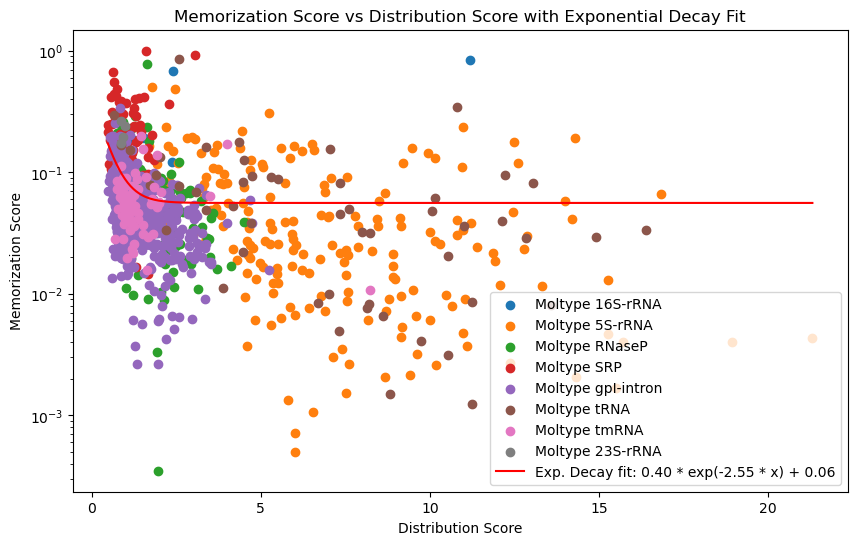

The exponential decay equation is: y = 0.40 * e^(-2.55 * x) + 0.06


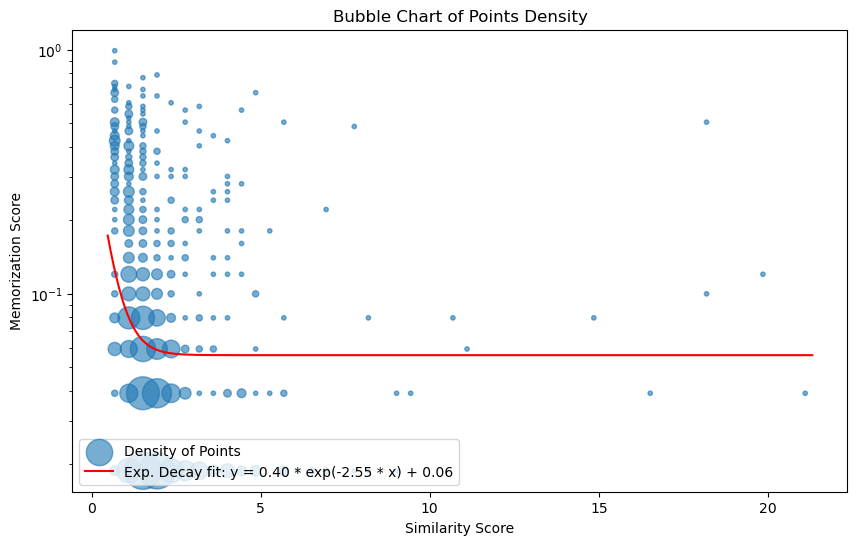

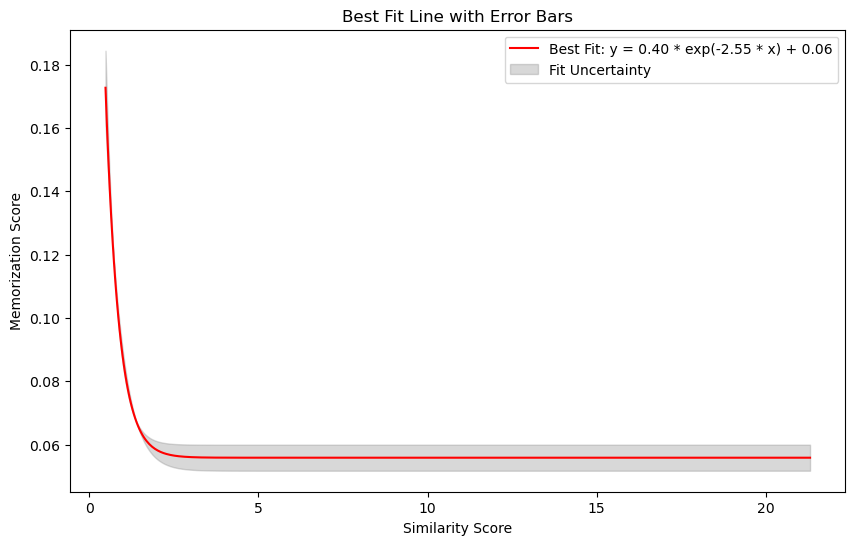

In [63]:
memscore_df['idx'] = memscore_df['idx'].astype(str) #ensuring both dataframes have the same data type for the idx column
similarity_scores_df['idx'] = similarity_scores_df['idx'].astype(str)

# Merging the two dataframes so each idx has a memorization score and a similarity score
merged_df = pd.merge(memscore_df, similarity_scores_df, on='idx', how='inner')
def exp_decay(x, a, b, c): # Exponential decay function to fit the data
    return a * np.exp(-b * x) + c

# Fitting data
x = merged_df['similarity_score']
y = merged_df['Memorization_Score']
initial_guess = [1, 1, 1]  # Initial guess for parameters a, b, c
params, covariance = curve_fit(exp_decay, x, y, p0=initial_guess)
x_fit = np.linspace(min(x), max(x), 500) # Generate x values for the fitted curve
y_fit = exp_decay(x_fit, *params)
moltypes = merged_df['moltype'].unique()  # Get unique moltypes
color_map = {moltype: color for moltype, color in zip(moltypes, plt.cm.tab10.colors[:len(moltypes)])}

# Plotting moltypes and all data points against the fitted curve
plt.figure(figsize=(10, 6))
for moltype in moltypes:
    subset = merged_df[merged_df['moltype'] == moltype]
    plt.scatter(subset['similarity_score'], subset['Memorization_Score'],
                color=color_map[moltype], label=f'Moltype {moltype}')
plt.plot(x_fit, y_fit, color='red', label=f'Exp. Decay fit: {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
plt.xlabel('Distribution Score')
plt.ylabel('Memorization Score')
plt.yscale('log')
plt.title('Memorization Score vs Distribution Score with Exponential Decay Fit')
plt.legend()
plt.show()
print(f'The exponential decay equation is: y = {params[0]:.2f} * e^(-{params[1]:.2f} * x) + {params[2]:.2f}')

# Plotting Bubble Chart to show density of points
plt.figure(figsize=(10, 6))
density, x_edges, y_edges = np.histogram2d(x, y, bins=50)
x_center = (x_edges[:-1] + x_edges[1:]) / 2
y_center = (y_edges[:-1] + y_edges[1:]) / 2
x_mesh, y_mesh = np.meshgrid(x_center, y_center)
plt.scatter(x_mesh.ravel(), y_mesh.ravel(), s=density.ravel()*10, alpha=0.6, label='Density of Points')
plt.plot(x_fit, y_fit, color='red', label=f'Exp. Decay fit: y = {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
plt.xlabel('Similarity Score')
plt.ylabel('Memorization Score')
plt.yscale('log')
plt.title('Bubble Chart of Points Density')
plt.legend()
plt.show()

# Best Fit Line with Error Bars
plt.figure(figsize=(10, 6))
perr = np.sqrt(np.diag(covariance)) # Calculate the standard deviation of the parameters
plt.plot(x_fit, y_fit, color='red', label=f'Best Fit: y = {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
y_err = exp_decay(x_fit, *(params + perr)) - exp_decay(x_fit, *params) # Add error bars for the fit
plt.fill_between(x_fit, y_fit - y_err, y_fit + y_err, color='gray', alpha=0.3, label='Fit Uncertainty')
plt.xlabel('Similarity Score')
plt.ylabel('Memorization Score')
plt.title('Best Fit Line with Error Bars')
plt.legend()
plt.show()




### Graphing the relationship between simmilarity score and memorization score as an exponential decay function for Levenshtein

/Users/ilanastern/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


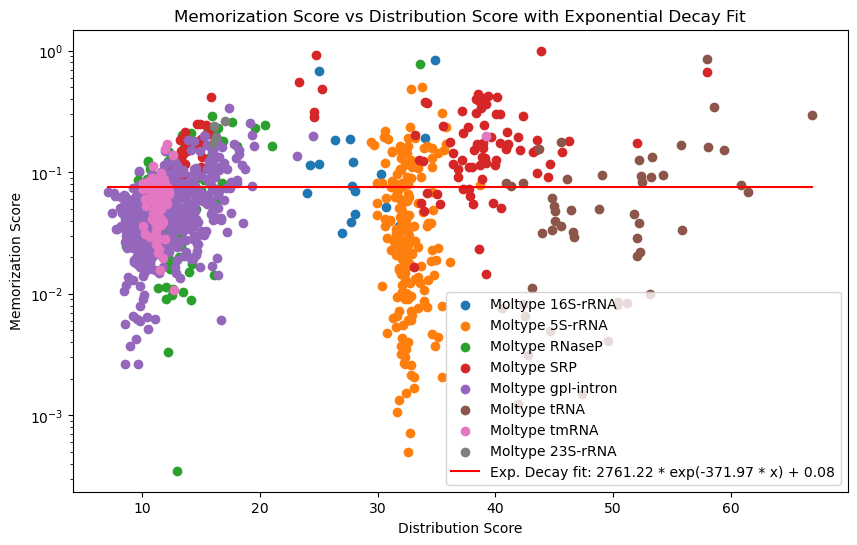

The exponential decay equation is: y = 2761.22 * e^(-371.97 * x) + 0.08


In [64]:
Levenstein_df['idx'] = Levenstein_df['idx'].astype(str)


# Merging the two dataframes so each idx has a memorization score and a similarity score
merged_df = pd.merge(memscore_df, Levenstein_df, on='idx', how='inner')
def exp_decay(x, a, b, c): # Exponential decay function to fit the data
    return a * np.exp(-b * x) + c

# Fitting data
x = merged_df['similarity_score']
y = merged_df['Memorization_Score']
initial_guess = [1, 1, 1]  # Initial guess for parameters a, b, c
params, covariance = curve_fit(exp_decay, x, y, p0=initial_guess)
x_fit = np.linspace(min(x), max(x), 500) # Generate x values for the fitted curve
y_fit = exp_decay(x_fit, *params)
moltypes = merged_df['moltype'].unique()  # Get unique moltypes
color_map = {moltype: color for moltype, color in zip(moltypes, plt.cm.tab10.colors[:len(moltypes)])}

# Plotting
plt.figure(figsize=(10, 6))
for moltype in moltypes:
    subset = merged_df[merged_df['moltype'] == moltype]
    plt.scatter(subset['similarity_score'], subset['Memorization_Score'],
               color=color_map[moltype], label=f'Moltype {moltype}')
plt.plot(x_fit, y_fit, color='red', label=f'Exp. Decay fit: {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
plt.xlabel('Distribution Score')
plt.ylabel('Memorization Score')
plt.yscale('log')
plt.title('Memorization Score vs Distribution Score with Exponential Decay Fit')
plt.legend()
plt.show()
print(f'The exponential decay equation is: y = {params[0]:.2f} * e^(-{params[1]:.2f} * x) + {params[2]:.2f}')


## Graphing the Relationship between VL f1 scores and TR f1 score (RNAForrester)

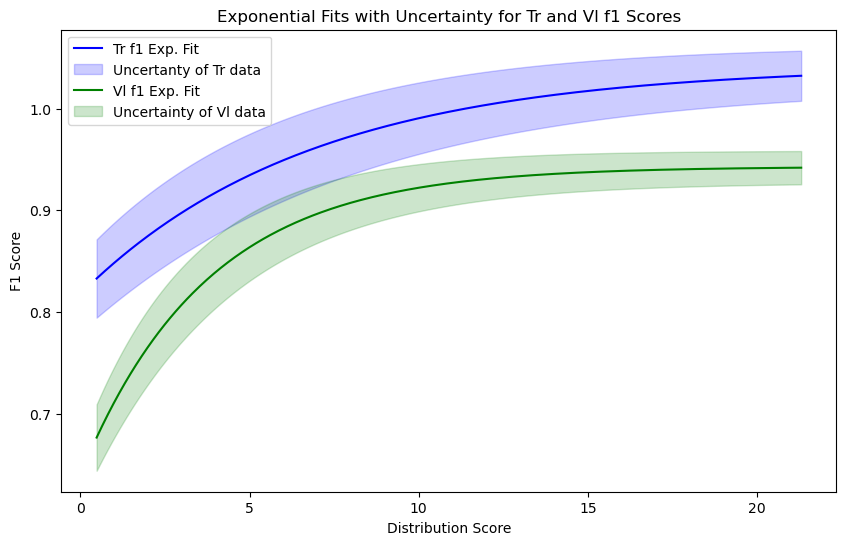

Tr_f1 fit: y = -0.22 * exp(-0.15 * x) + 1.04
Vl_f1 fit: y = -0.30 * exp(-0.27 * x) + 0.94


In [79]:
memscore_df['idx'] = memscore_df['idx'].astype(str)# Convert the idx columns to the same type
similarity_scores_df['idx'] = similarity_scores_df['idx'].astype(str)

# Merge the two dataframes based on 'idx'
merged_df_tr = pd.merge(memscore_df[['idx', 'tr_avg_f1']], similarity_scores_df[['idx', 'similarity_score']], on='idx', how='inner')
merged_df_vl = pd.merge(memscore_df[['idx', 'vl_avg_f1']], similarity_scores_df[['idx', 'similarity_score']], on='idx', how='inner')
tr_f1 = merged_df_tr['tr_avg_f1']
vl_f1 = merged_df_vl['vl_avg_f1']
distribution_score = merged_df_tr['similarity_score']

# Fitting data
params_tr, covariance_tr = curve_fit(exp_decay, distribution_score, tr_f1, p0=[1, 1, 1])
perr_tr = np.sqrt(np.diag(covariance_tr))  # Standard error for Tr_f1 fit
params_vl, covariance_vl = curve_fit(exp_decay, distribution_score, vl_f1, p0=[1, 1, 1])
perr_vl = np.sqrt(np.diag(covariance_vl))  # Standard error for Vl_f1 fit

# Generate values for fitted curves
x_fit = np.linspace(min(distribution_score), max(distribution_score), 500)
y_tr_fit = exp_decay(x_fit, *params_tr)
y_vl_fit = exp_decay(x_fit, *params_vl)

# Calculate uncertainties 
y_tr_err = exp_decay(x_fit, *(params_tr + perr_tr)) - exp_decay(x_fit, *params_tr)
y_vl_err = exp_decay(x_fit, *(params_vl + perr_vl)) - exp_decay(x_fit, *params_vl)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_fit, y_tr_fit, color='blue', label='Tr f1 Exp. Fit')
plt.fill_between(x_fit, y_tr_fit - y_tr_err, y_tr_fit + y_tr_err, color='blue', alpha=0.2, label='Uncertanty of Tr data')
plt.plot(x_fit, y_vl_fit, color='green', label='Vl f1 Exp. Fit')
plt.fill_between(x_fit, y_vl_fit - y_vl_err, y_vl_fit + y_vl_err, color='green', alpha=0.2, label='Uncertainty of Vl data')
plt.xlabel('Distribution Score')
plt.ylabel('F1 Score')
plt.title('Exponential Fits with Uncertainty for Tr and Vl f1 Scores')
plt.legend()
plt.show()
print(f'Tr_f1 fit: y = {params_tr[0]:.2f} * exp(-{params_tr[1]:.2f} * x) + {params_tr[2]:.2f}')
print(f'Vl_f1 fit: y = {params_vl[0]:.2f} * exp(-{params_vl[1]:.2f} * x) + {params_vl[2]:.2f}')
